db에서 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine

In [2]:
# 1. 데이터베이스 연결 -> 연결 객체 반환
conn = pymysql.connect(host="localhost", port=3306, db="mp",
                       user="root", passwd="1234", cursorclass=pymysql.cursors.DictCursor)

cursor = conn.cursor()

In [3]:
# 3. SQL 작성 + 명령 실행 ( 조회 명령 )
sql = """select * from fine_dust"""
cursor.execute(sql)
result = cursor.fetchall()
result

[{'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-01',
  'fine_dust(㎍/㎥)': 36},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-02',
  'fine_dust(㎍/㎥)': 43},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-03',
  'fine_dust(㎍/㎥)': 47},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-04',
  'fine_dust(㎍/㎥)': 50},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-05',
  'fine_dust(㎍/㎥)': 37},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-06',
  'fine_dust(㎍/㎥)': 30},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-07',
  'fine_dust(㎍/㎥)': 56},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-08',
  'fine_dust(㎍/㎥)': 27},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-09',
  'fine_dust(㎍/㎥)': 33},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021-01-10',
  'fine_dust(㎍/㎥)': 48},
 {'station_id': 108,
  'station_name': '서울',
  'date': '2021

In [4]:
fine_dust_df = pd.DataFrame(result)
fine_dust_df.head()

,station_id,station_name,date,fine_dust(㎍/㎥)
0,108,서울,2021-01-01,36
1,108,서울,2021-01-02,43
2,108,서울,2021-01-03,47
3,108,서울,2021-01-04,50
4,108,서울,2021-01-05,37


In [5]:
conn.close()
cursor.close()

In [6]:
fine_dust_df.to_csv('./data/fine_dust.csv')

In [7]:
# conn = pymysql.connect(host="localhost", port=3306, db="project", 
#                        user="humanda", password="humanda")


# sql3 = "select * from transportation"

# transportation = pd.read_sql_query(sql3, conn)

### db 종료 후 DF으로 작업하기

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


In [10]:
fine_dust_df = pd.read_csv('./data/fine_dust.csv')
fine_dust_df.columns

Index(['Unnamed: 0', 'station_id', 'station_name', 'date', 'fine_dust(㎍/㎥)'], dtype='object')

In [11]:
# 필요 컬럼만 자르기
fine_dust = fine_dust_df.loc[:, ['date', 'fine_dust(㎍/㎥)']] # 잘랐으면 비활성화 안 잘랐으면 활성화
fine_dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1323 non-null   object
 1   fine_dust(㎍/㎥)  1323 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.8+ KB


In [12]:
# 좋음 (0-30 ㎍/m³) → Good
# 보통 (31-80 ㎍/m³) → Moderate
# 나쁨 (81-150 ㎍/m³) → Bad / Poor / Unhealthy
# 매우 나쁨 (151 ㎍/m³ 이상) → Very Bad / Very Poor / Very Unhealthy

In [13]:
# 미세먼지 농도 범위에 따른 데이터프레임 분리
good_df = fine_dust[fine_dust['fine_dust(㎍/㎥)'] <= 30]
normal_df = fine_dust[(fine_dust['fine_dust(㎍/㎥)'] > 30) & (fine_dust['fine_dust(㎍/㎥)'] <= 80)]
bad_df = fine_dust[(fine_dust['fine_dust(㎍/㎥)'] > 80) & (fine_dust['fine_dust(㎍/㎥)'] <= 150)]
very_bad_df = fine_dust[fine_dust['fine_dust(㎍/㎥)'] > 150]

In [14]:
# 조건 설정
conditions = [
    (fine_dust['fine_dust(㎍/㎥)'] <= 30),
    (fine_dust['fine_dust(㎍/㎥)'] > 30) & (fine_dust['fine_dust(㎍/㎥)'] <= 80),
    (fine_dust['fine_dust(㎍/㎥)'] > 80) & (fine_dust['fine_dust(㎍/㎥)'] <= 150),
    (fine_dust['fine_dust(㎍/㎥)'] > 150)
]

# 각 조건에 따른 값
values = ['good', 'normal', 'bad', 'very_bad']

# 새로운 'grade' 컬럼 추가 (default 값을 설정해 오류 해결)
fine_dust['grade'] = np.select(conditions, values, default='unknown')

# 결과 확인
fine_dust.tail()

,date,fine_dust(㎍/㎥),grade
1318,2024-10-25,29,good
1319,2024-10-26,26,good
1320,2024-10-27,27,good
1321,2024-10-28,38,normal
1322,2024-10-30,28,good


In [15]:
# 날짜 컬럼을 datetime 형식으로 변환
fine_dust['date'] = pd.to_datetime(fine_dust['date'])

# 연도, 계절, 평일/주말 정보 추가
fine_dust['year'] = fine_dust['date'].dt.year
fine_dust['weekday'] = np.where(fine_dust['date'].dt.dayofweek < 5, 'weekday', 'weekend')

# 등급과 평일/주말에 따른 데이터 수 세기
count_data = fine_dust.groupby(['grade', 'weekday']).size().unstack().fillna(0)



In [29]:
# 계절 구분하기 (봄: 3~5, 여름: 6~8, 가을: 9~11, 겨울: 12~2)
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

fine_dust['season'] = fine_dust['date'].dt.month.apply(get_season)


In [30]:
# 등급 순서 정의
grade_categories = ['good', 'normal', 'bad', 'very_bad']  # 원하는 순서
grade_order = pd.CategoricalDtype(categories=grade_categories, ordered=True)
season_order = pd.CategoricalDtype(categories=['Spring', 'Summer', 'Fall', 'Winter'], ordered=True)

# 데이터프레임의 grade 열을 순서가 있는 카테고리형으로 변환
fine_dust['grade'] = fine_dust['grade'].astype(grade_order)
fine_dust['season'] = fine_dust['season'].astype(season_order)

# 데이터 그룹화
grouped_data = fine_dust.groupby(['year', 'season', 'grade']).size().unstack(fill_value=0)

# 원하는 순서대로 컬럼 재정렬
grouped_data = grouped_data[grade_categories]

C:\Users\human\AppData\Local\Temp\ipykernel_8092\4154734158.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = fine_dust.groupby(['year', 'season', 'grade']).size().unstack(fill_value=0)


In [31]:
fine_dust

,date,fine_dust(㎍/㎥),grade,year,weekday,season
0,2021-01-01,36,normal,2021,weekday,Winter
1,2021-01-02,43,normal,2021,weekend,Winter
2,2021-01-03,47,normal,2021,weekend,Winter
3,2021-01-04,50,normal,2021,weekday,Winter
4,2021-01-05,37,normal,2021,weekday,Winter
...,...,...,...,...,...,...
1318,2024-10-25,29,good,2024,weekday,Fall
1319,2024-10-26,26,good,2024,weekend,Fall
1320,2024-10-27,27,good,2024,weekend,Fall
1321,2024-10-28,38,normal,2024,weekday,Fall


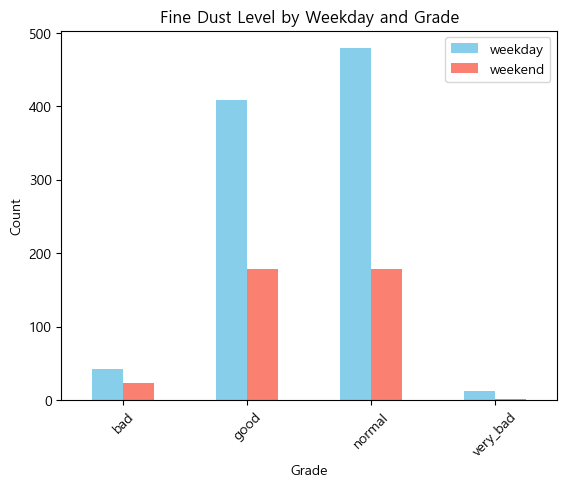

In [18]:
# 그래프 그리기
count_data.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.title("Fine Dust Level by Weekday and Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()

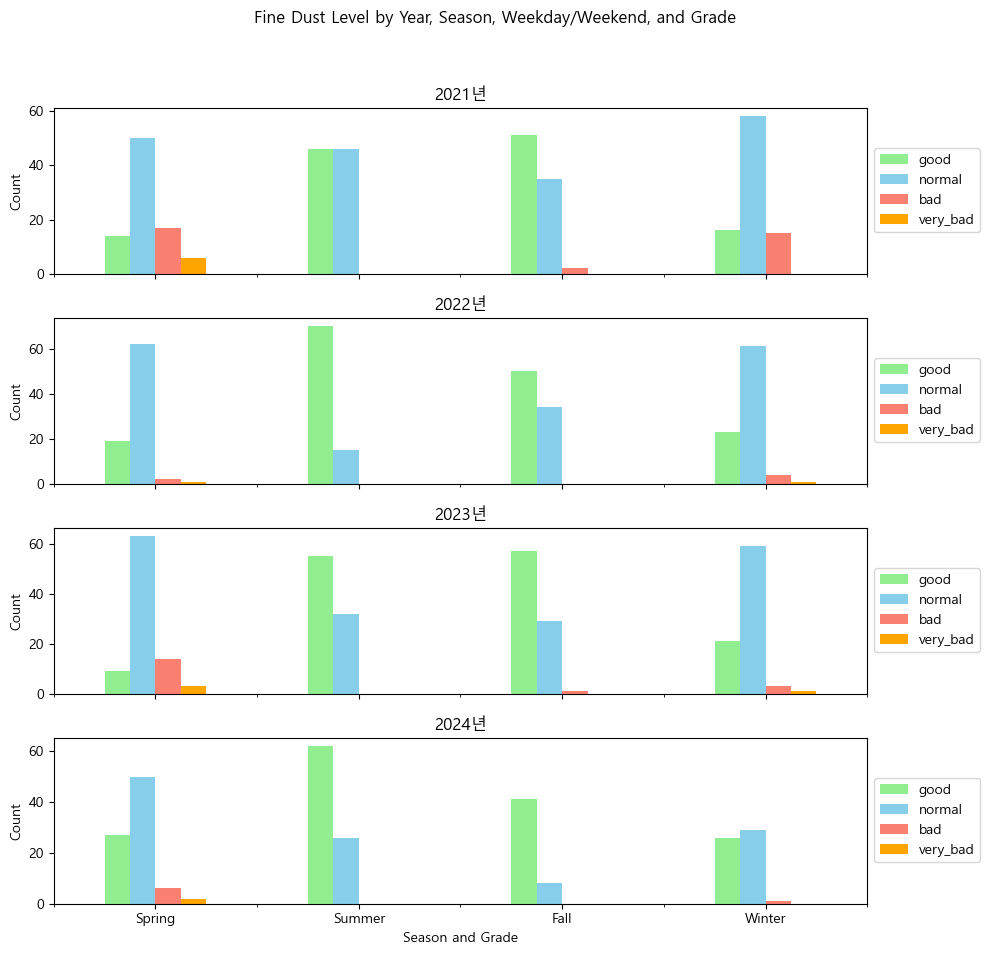

In [33]:
# 그래프 그리기
fig, axes = plt.subplots(len(grouped_data.index.levels[0]), 1, figsize=(10, 10), sharex=True)
fig.suptitle("Fine Dust Level by Year, Season, Weekday/Weekend, and Grade")

# 색상 정의 (순서대로 good, normal, bad, very_bad에 대응)
colors = ['lightgreen', 'skyblue', 'salmon', 'orange']

# 각 연도별로 서브플롯에 그래프 생성
for i, (year, data) in enumerate(grouped_data.groupby(level=0)):
    data = data.droplevel(0)  # 연도 레벨 제거
    
    # season_order에 따라 계절 순서 정렬
    data = data.loc[season_order.categories]
    
    # 정의된 순서대로 그래프 그리기
    ax = data.plot(kind='bar', stacked=False, ax=axes[i], color=colors)
    axes[i].set_title(f"{year}년")
    axes[i].set_ylabel("Count")
    
    # x축 레이블 회전 제거
    axes[i].tick_params(axis='x', rotation=0)
    
    # 범례 순서 명시적 지정
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, bbox_to_anchor=(1, 0.8))

plt.xlabel("Season and Grade")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()